In [8]:
# Pasting these here for easier access

import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count
import os
import sys
import time
import datetime 

In [14]:
# Define the range for pmax_art
min_pmax = 0.999999
max_pmax = 0.9999999

# Define pmax_art values
pmax_values = np.linspace(min_pmax, max_pmax, 100)  # 50 values between 0.99997 and 0.8

# Initialize a grid to store the clearance rates
clearance_rates = np.zeros(len(pmax_values))

print(pmax_values)

[0.999999   0.99999901 0.99999902 0.99999903 0.99999904 0.99999905
 0.99999905 0.99999906 0.99999907 0.99999908 0.99999909 0.9999991
 0.99999911 0.99999912 0.99999913 0.99999914 0.99999915 0.99999915
 0.99999916 0.99999917 0.99999918 0.99999919 0.9999992  0.99999921
 0.99999922 0.99999923 0.99999924 0.99999925 0.99999925 0.99999926
 0.99999927 0.99999928 0.99999929 0.9999993  0.99999931 0.99999932
 0.99999933 0.99999934 0.99999935 0.99999935 0.99999936 0.99999937
 0.99999938 0.99999939 0.9999994  0.99999941 0.99999942 0.99999943
 0.99999944 0.99999945 0.99999945 0.99999946 0.99999947 0.99999948
 0.99999949 0.9999995  0.99999951 0.99999952 0.99999953 0.99999954
 0.99999955 0.99999955 0.99999956 0.99999957 0.99999958 0.99999959
 0.9999996  0.99999961 0.99999962 0.99999963 0.99999964 0.99999965
 0.99999965 0.99999966 0.99999967 0.99999968 0.99999969 0.9999997
 0.99999971 0.99999972 0.99999973 0.99999974 0.99999975 0.99999975
 0.99999976 0.99999977 0.99999978 0.99999979 0.9999998  0.999999

In [1]:
def run_simulation(idx, pmax):
    command_pmax_artemether_adj = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "10000",
        "--pmax_artemether", str(pmax),
        "--pmax_lum", "0",
        "--weight", "54",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_pmax_artemether_adj = subprocess.run(command_pmax_artemether_adj, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmax_artemether_adj = output_pmax_artemether_adj.stdout.splitlines()
        df_pmax_artemether_adj = pd.DataFrame(
            [line.split() for line in lines_pmax_artemether_adj],
            columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_pmax_artemether_adj = df_pmax_artemether_adj.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_pmax_artemether_adj[df_pmax_artemether_adj['PARASITEDENSITY'] >= 10].shape[0]
        total_patients = df_pmax_artemether_adj['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_pmax_artemether_adj)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for pmax_artemether: {pmax}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

    except Exception as e:
        print(f"An unexpected error occurred for pmax_artemether: {pmax}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

In [16]:
# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, pmax_values[i]) for i in range(len(pmax_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            idx, efficacy, df_pmax_artemether_adj = result
            results.append((idx, efficacy, df_pmax_artemether_adj))
            if df_pmax_artemether_adj is not None:
                dfs.append(df_pmax_artemether_adj)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy, df_pmax_artemether_adj in results:
    clearance_rates[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'pmax_art': pmax_values,
    'efficacy': clearance_rates
})

# Save the DataFrame to a pickle file
df.to_pickle("pkpd_AL_pmax_artemether_test_01_efficacy.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle("pkpd_AL_pmax_art_test_01_results.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv("pkpd_AL_pmax_art_test_01_efficacy.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 100/100 [52:09<00:00, 31.30s/it]   

DataFrame saved as pickle and CSV files successfully.


In [17]:
df_pmax_artemether_adj 

,PID,HOUR,COMP2CONC_ART,COMP2CONC_LUM,PARASITEDENSITY
1,0,671.0,0.0,0.0,457.810
2,1,671.0,0.0,0.0,0.333
3,2,671.0,0.0,0.0,0.000
4,3,671.0,0.0,0.0,58.748
5,4,671.0,0.0,0.0,0.012
...,...,...,...,...,...
9996,9995,671.0,0.0,0.0,0.001
9997,9996,671.0,0.0,0.0,0.002
9998,9997,671.0,-0.0,0.0,3411.436
9999,9998,671.0,0.0,0.0,0.001


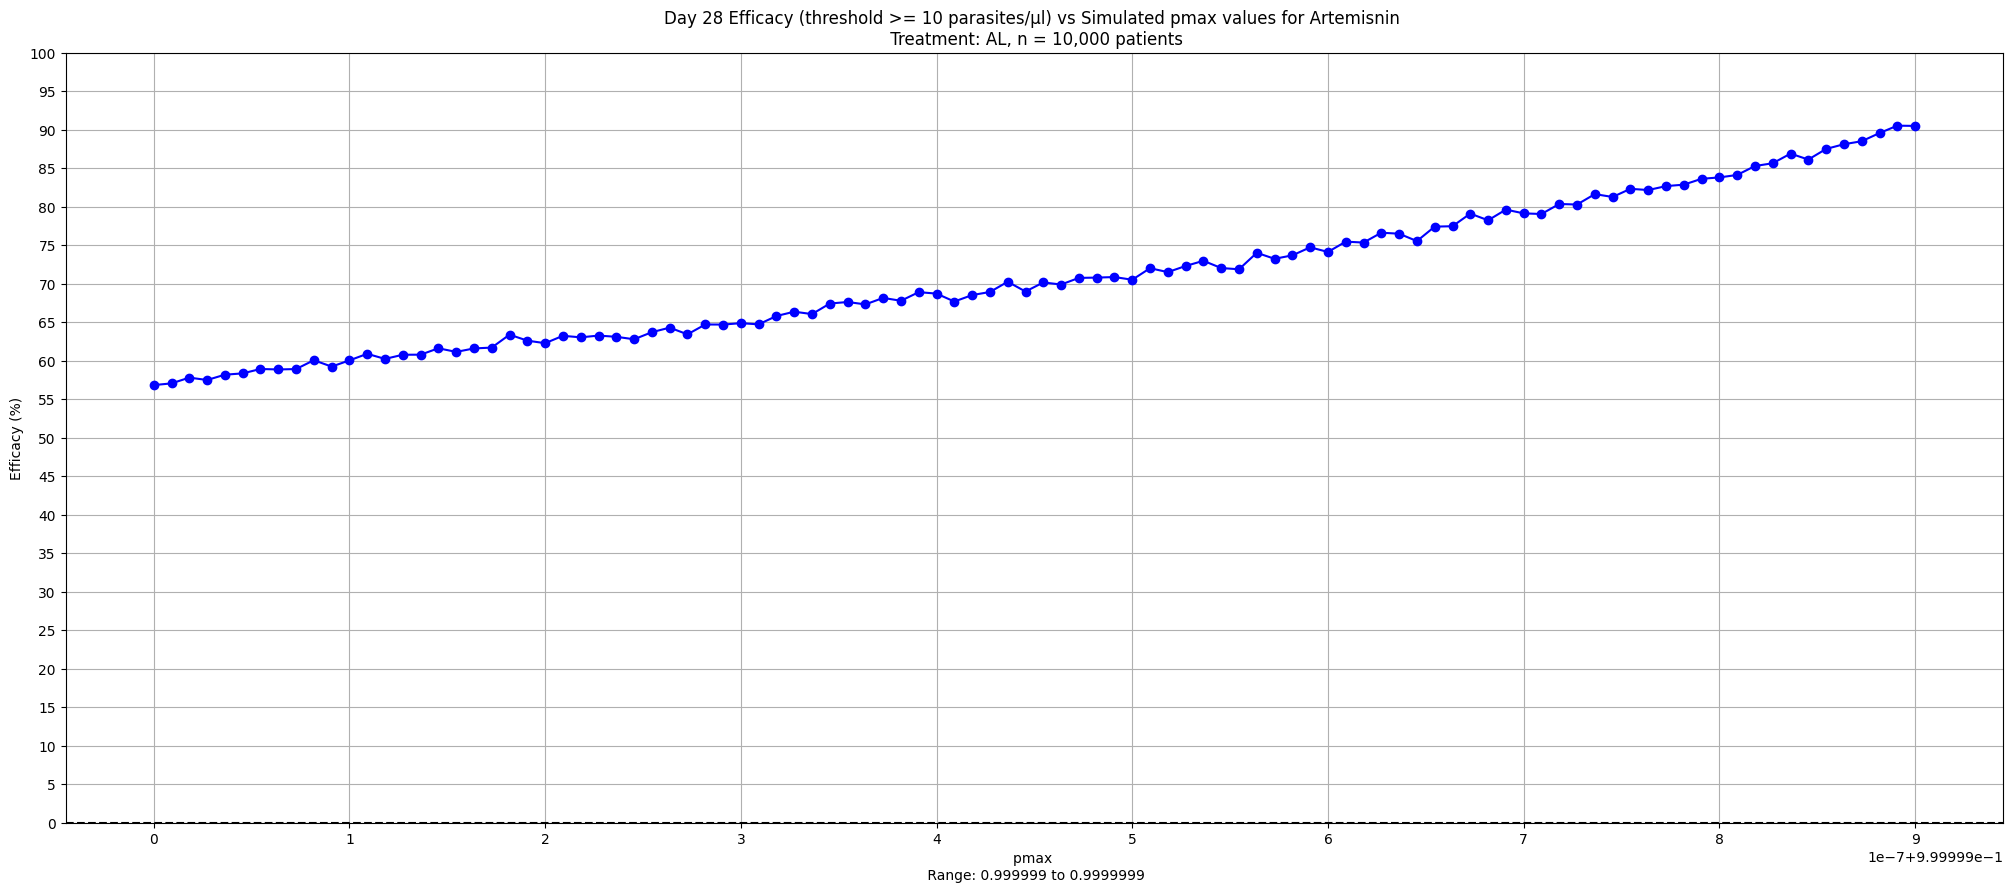

In [28]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, clearance_rates, marker='o', linestyle='-', color='b')
plt.xlabel(f'pmax \n Range: {min(pmax_values)} to {max(pmax_values)}')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated pmax values for Artemisnin \n Treatment: AL, n = 10,000 patients")
plt.grid(True)
plt.xticks(np.arange(min(pmax_values), max(pmax_values), 0.0000001))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_pmax_art_test_01_efficacy.png")  # Save the plot as a PNG file
plt.show()

In [29]:
df[(df['efficacy'] > 68) & (df['efficacy'] <= 69)]

,pmax_art,efficacy
41,0.999999,68.13
43,0.999999,68.88
44,0.999999,68.69
46,0.999999,68.50
47,0.999999,68.90
49,0.999999,68.96


In [9]:
# Define the range for pmax_art
min_ec50 = 1
max_ec50 = 100

# Define pmax_art values
ec50_values = np.linspace(min_ec50, max_ec50, 100)  # 50 values between 0.99997 and 0.8

# Initialize a grid to store the clearance rates
clearance_rates = np.zeros(len(ec50_values))

print(ec50_values)

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100.]


In [10]:
def run_simulation(idx, ec50):
    command_ec50_lum_adj = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "10000",
        "--pmax_artemether","0.9999994",
        "--ec50_lum", str(ec50),
        "--weight", "54",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_ec50_lum_adj = subprocess.run(command_ec50_lum_adj, capture_output=True, text=True, check=True)

        # Process the output
        lines_ec50_lum_adj = output_ec50_lum_adj.stdout.splitlines()
        df_ec50_lum_adj = pd.DataFrame(
            [line.split() for line in lines_ec50_lum_adj],
            columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_ec50_lum_adj = df_ec50_lum_adj.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_ec50_lum_adj[df_ec50_lum_adj['PARASITEDENSITY'] >= 10].shape[0]
        total_patients = df_ec50_lum_adj['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_ec50_lum_adj)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for ec50_lum: {ec50}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

    except Exception as e:
        print(f"An unexpected error occurred for ec50_lum: {ec50}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

In [11]:
# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, ec50_values[i]) for i in range(len(ec50_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            idx, efficacy, df_ec50_lum_adj = result
            results.append((idx, efficacy, df_ec50_lum_adj))
            if df_ec50_lum_adj is not None:
                dfs.append(df_ec50_lum_adj)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy, df_ec50_lum_adj in results:
    clearance_rates[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'ec50_lum': ec50_values,
    'efficacy': clearance_rates
})

# Save the DataFrame to a pickle file
df.to_pickle("pkpd_AL_ec50_lum_test_01_efficacy.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle("pkpd_AL_ec50_lum_test_01_results.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv("pkpd_AL_ec50_lum_test_01_efficacy.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 100/100 [1:19:38<00:00, 47.79s/it]    

DataFrame saved as pickle and CSV files successfully.


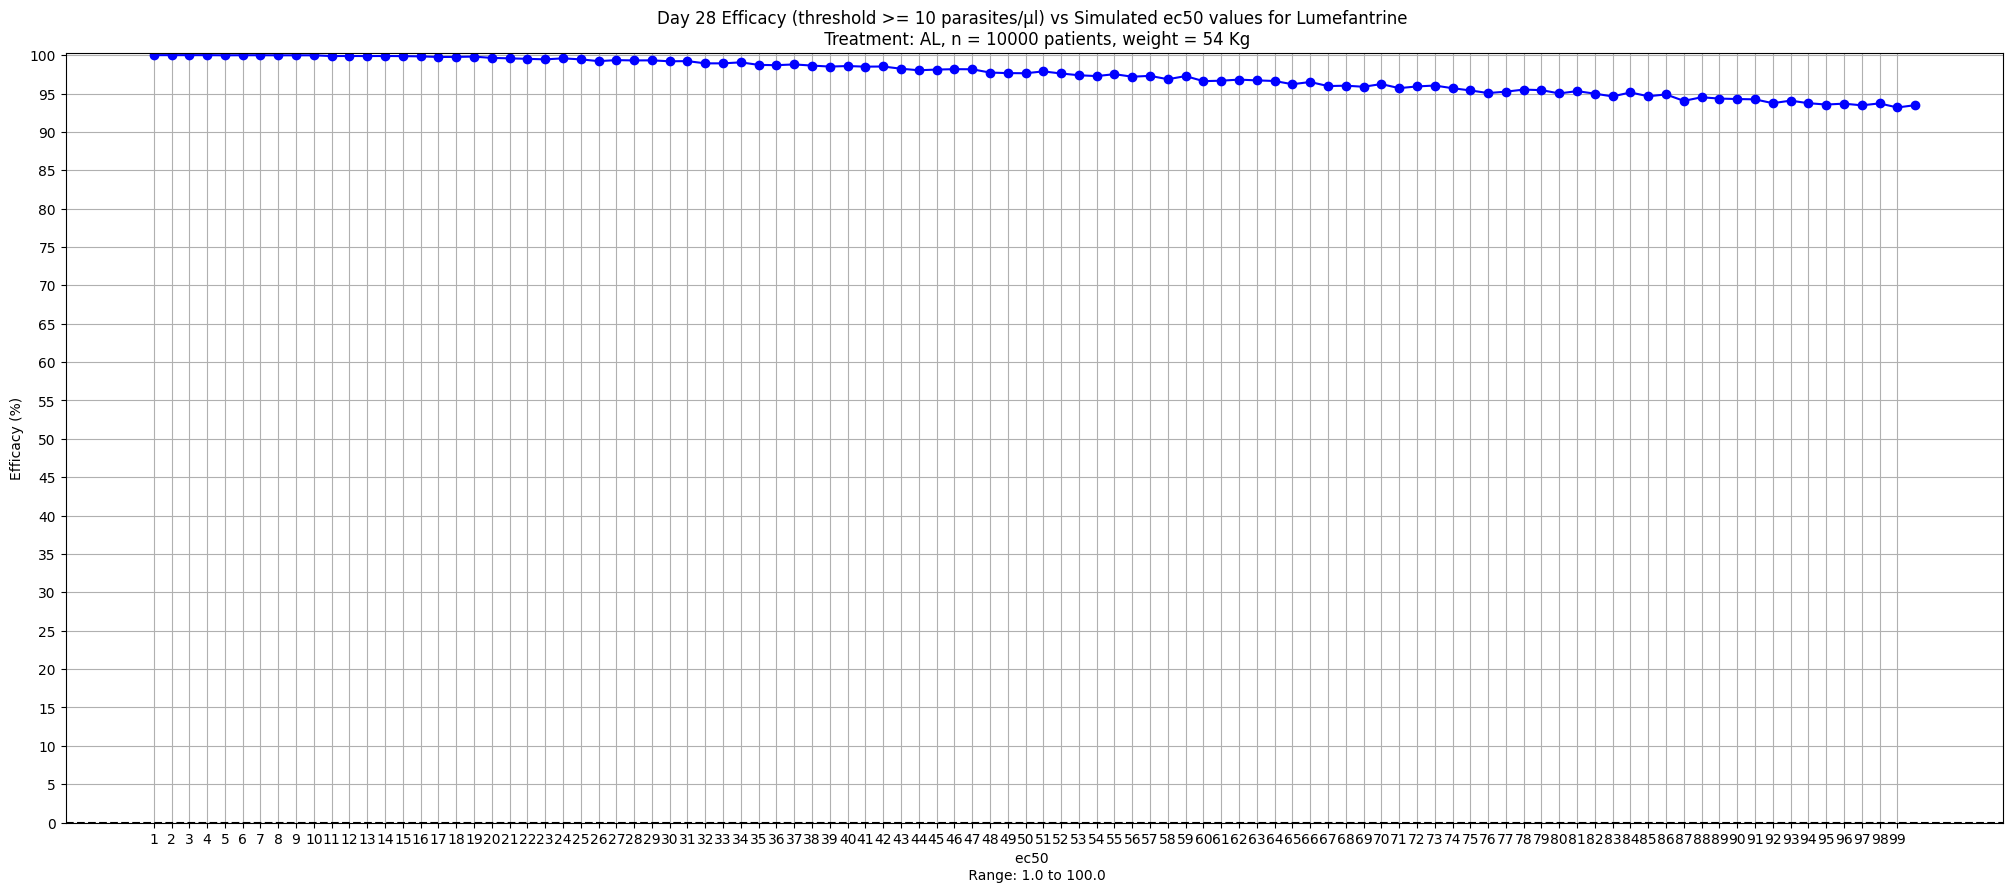

In [13]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(ec50_values, clearance_rates, marker='o', linestyle='-', color='b')
plt.xlabel(f'ec50 \n Range: {min(ec50_values)} to {max(ec50_values)}')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated ec50 values for Lumefantrine \n Treatment: AL, n = 10000 patients, weight = 54 Kg")
plt.grid(True)
plt.xticks(np.arange(min(ec50_values), max(ec50_values), 1))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_ec50_lum_test_01_efficacy.png")  # Save the plot as a PNG file
plt.show()

In [14]:
df[(df['efficacy'] >= 96) & (df['efficacy'] <= 97)]

,ec50_lum,efficacy
57,58.0,96.86
59,60.0,96.61
60,61.0,96.67
61,62.0,96.81
62,63.0,96.71
63,64.0,96.63
64,65.0,96.21
65,66.0,96.50
67,68.0,96.02
69,70.0,96.23
